In [1]:
from ultralytics import YOLO
import torch

In [2]:
model = YOLO("YOLO11m-seg.pt")

In [3]:
device = 0 if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
# para usar GPU en caso de tenerla

#1 pip3 install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
#2 restart kernel

Using device: cpu
PyTorch version: 2.6.0+cpu


In [117]:
import os
import glob
import numpy as np

def detectar_outlier(points, threshold=0.5):
    """
    Detecta el índice del punto que es outlier por su distancia.
    Usa distancia entre cada punto y sus vecinos.
    """
    num_points = len(points)
    distancias = []

    for i in range(num_points):
        prev_point = points[i - 1]
        curr_point = points[i]
        next_point = points[(i + 1) % num_points]

        # Vector entre vecinos
        d1 = np.linalg.norm(np.array(curr_point) - np.array(prev_point))
        d2 = np.linalg.norm(np.array(curr_point) - np.array(next_point))

        distancias.append((d1 + d2) / 2)

    distancias = np.array(distancias)
    promedio = np.mean(distancias)
    std = np.std(distancias)

    for i, d in enumerate(distancias):
        if d > promedio + threshold * std:
            return i  # Índice del outlier

    return None  # No se detectó ningún outlier

def procesar_txt(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    nuevas_lineas = []
    for line in lines:
        partes = line.strip().split()
        if len(partes) <= 3:
            continue  # No hay puntos suficientes

        label_box = partes[0]
        # me salto box, primera y ultima
        coords = list(map(float, partes[7:-2]))

        puntos = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]

        if len(puntos) <= 3:
            nuevas_lineas.append(line)
            continue  # No se puede eliminar más puntos

        outlier_idx = detectar_outlier(puntos)

        # if outlier_idx is not None:
        #     # Eliminar punto outlier
        #     print(f'se borro el punto {puntos[outlier_idx]}')
        #     puntos.pop(outlier_idx)
        #     coords_filtradas = [str(c) for punto in puntos for c in punto]
        #     nueva_linea = label_box + " " + " ".join(coords_filtradas) + "\n"
        #     nuevas_lineas.append(nueva_linea)
        # else:
        nuevas_lineas.append(label_box + " " + " ".join(list(map(str,coords))) + "\n")

    # Sobrescribir archivo original
    with open(file_path, 'w') as f:
        f.writelines(nuevas_lineas)

def procesar_directorio_txt(ruta):
    archivos = glob.glob(os.path.join(ruta, '*.txt'))
    for file in archivos:
        procesar_txt(file)
    print(f"Procesados {len(archivos)} archivos.")

# 🟢 Usa tu ruta aquí:
ruta_txts = r"C:\Users\jmonsalvo\Documents\00_Projects_Python\02_Federico_Guerrero\XX_entrenamiento_H4\00_Data\YOLODataset_H4_Segmentation\labels"
procesar_directorio_txt(ruta_txts)

Procesados 1100 archivos.


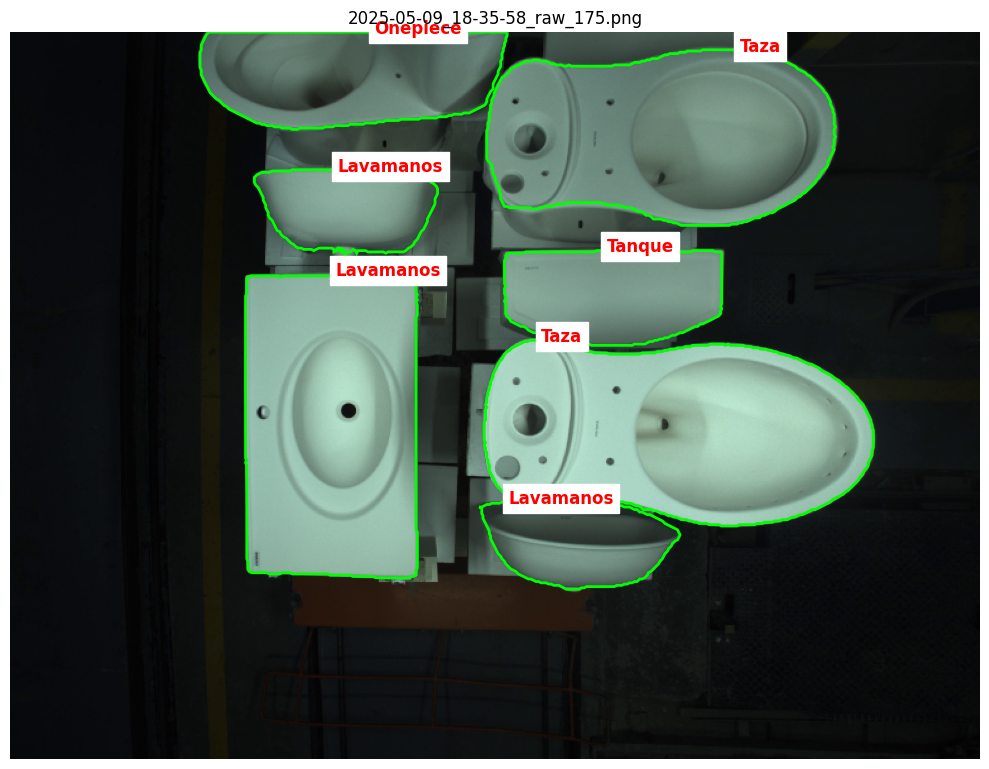

In [4]:
import os
import yaml
import cv2 as cv
import random
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def cargar_clases_desde_yaml(yaml_path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    return data['names']

def draw_yolo_segmentation(dataset_dir, n=5):
    # image_dir = os.path.join(dataset_dir, 'images')
    # label_dir = os.path.join(dataset_dir, 'labels')
    image_dir = os.path.join(dataset_dir, 'images/train')
    label_dir = os.path.join(dataset_dir, 'labels/train')
    yaml_path = os.path.join(dataset_dir, 'yolo_dataset.yaml')
    
    class_names = cargar_clases_desde_yaml(yaml_path)

    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    muestras = random.sample(image_files, min(n, len(image_files)))

    for filename in muestras:
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))

        image = cv.imread(image_path)
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(image_rgb)
        ax.set_title(filename)

        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                lines = file.readlines()

            for line in lines:
                parts = line.strip().split()
                class_id = int(parts[0])
                coords = list(map(float, parts[1:]))  

                # Convertir coordenadas normalizadas a píxeles
                points = np.array([[x * w, y * h] for x, y in zip(coords[0::2], coords[1::2])])

                # Crear polígono
                polygon = patches.Polygon(points, closed=True, edgecolor='lime', facecolor='none', linewidth=2)
                ax.add_patch(polygon)

                label = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                ax.text(points[0][0], points[0][1], label,
                        color='red', fontsize=12, weight='bold', backgroundcolor='white')

        ax.axis('off')
        plt.tight_layout()
        plt.show()


draw_yolo_segmentation(
    dataset_dir=r'C:\Users\jmonsalvo\Documents\00_Projects_Python\02_Federico_Guerrero\XX_entrenamiento_H4\00_Data\00_YOLODataset_H4_Segmentation_Split_0.7-0.3'
    # dataset_dir=r'C:\Users\jmonsalvo\Documents\00_Projects_Python\02_Federico_Guerrero\XX_entrenamiento_H4\00_Data\YOLODataset_H4_Segmentation'
    , n=1)

In [ ]:
model = model.train(
    data=r'C:\Users\jmonsalvo\Documents\00_Projects_Python\02_Federico_Guerrero\XX_entrenamiento_H4\00_Data\00_YOLODataset_H4_Segmentation_Split_0.7-0.3\yolo_dataset.yaml',
    epochs=100,
    batch=5,
    rect=True,
    device=device,
    workers=8,
    seed=0,
    project="runs/train",
    name="Entrada_H4_YOLO_V2_",
    # patience = 20,
    resume= False,
    optimizer= 'auto', # SGD, Adam, AdamW, NAdam, RAdam, RMSProp
    lr0= 0.01, 
    val= True,
    plots= True,
    # Image Augmentation
    augment=True,
    hsv_h= 0.015, # Ajuste del tono 0-1
    hsv_s= 0.5,   # Ajuste Saturación  0-1
    hsv_v= 0.9,   # Ajuste del brillo 0 - 1
    degrees= 0,  # Rotación 0-180 # probar 90 en otra version para validar en salida
    translate= 0,
    scale= 0,
    shear= 0,
    perspective= 0.0005,
    flipud= 0.1,  # Vertical Flip probability
    fliplr= 0.2,  # Horizontal Flip probability
    erasing= 0.4,
    mosaic= 0,
    mixup= 0,
)
# v2_6 -> train time early stopping at 68 : 15:23
# v2_7 -> train 100 epoch : 21:36

Ultralytics 8.3.159  Python-3.10.11 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=5, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jmonsalvo\Documents\00_Projects_Python\02_Federico_Guerrero\XX_entrenamiento_H4\00_Data\00_YOLODataset_H4_Segmentation_Split_0.7-0.3\yolo_dataset.yaml, degrees=0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.2, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5, hsv_v=0.9, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0, mode=train, model=YOLO11m-seg.pt, momentum=0.937, mosaic=0, multi_scale=False, name=Entrada_H4_YOL

train: Scanning C:\Users\jmonsalvo\Documents\00_Projects_Python\02_Federico_Guerrero\XX_entrenamiento_H4\00_Data\00_YOLODataset_H4_Segmentation_Split_0.7-0.3\labels\train.cache... 770 images, 5 backgrounds, 0 corrupt: 100%|██████████| 770/770 [00:00<?, ?it/s]

WARNING 'rect=True' is incompatible with DataLoader shuffle, setting shuffle=False


val: Fast image access  (ping: 0.10.0 ms, read: 1189.7282.4 MB/s, size: 533.9 KB)


val: Scanning C:\Users\jmonsalvo\Documents\00_Projects_Python\02_Federico_Guerrero\XX_entrenamiento_H4\00_Data\00_YOLODataset_H4_Segmentation_Split_0.7-0.3\labels\val.cache... 330 images, 1 backgrounds, 0 corrupt: 100%|██████████| 330/330 [00:00<?, ?it/s]

val: C:\Users\jmonsalvo\Documents\00_Projects_Python\02_Federico_Guerrero\XX_entrenamiento_H4\00_Data\00_YOLODataset_H4_Segmentation_Split_0.7-0.3\images\val\2025-05-11_12-38-29_raw_125.png: 1 duplicate labels removed


Plotting labels to runs\train\Entrada_H4_YOLO_V2_7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005078125), 125 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\train\Entrada_H4_YOLO_V2_7
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.48G     0.4887     0.7027     0.7877     0.8927         69        640: 100%|██████████| 154/154 [00:10<00:00, 14.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.04it/s]

                   all        330       4050      0.867      0.902       0.94      0.826      0.867      0.902      0.939      0.841



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.93G     0.4864     0.5499     0.4939     0.8584         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.40it/s]

                   all        330       4050      0.893      0.943      0.971      0.869      0.891      0.942       0.97      0.869



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.93G     0.5051     0.5103     0.4503     0.8585         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.45it/s]

                   all        330       4050      0.943      0.959      0.971      0.852      0.943      0.959      0.971      0.891



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.93G     0.4942     0.5403     0.4117     0.8589         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.35it/s]

                   all        330       4050      0.957      0.968      0.987      0.853      0.957      0.968      0.987      0.908



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.93G     0.4702     0.4987     0.3768     0.8506         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 14.95it/s]

                   all        330       4050      0.967      0.973      0.986      0.902      0.967      0.973      0.986      0.892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.93G     0.4305     0.4495      0.347     0.8401         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 14.88it/s]

                   all        330       4050      0.971      0.982       0.99      0.913       0.97      0.982      0.989      0.916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.93G     0.4072     0.4398     0.3214     0.8364         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 14.99it/s]

                   all        330       4050      0.964      0.986      0.987      0.908      0.964      0.986      0.987      0.914



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.93G     0.4086     0.4446     0.3197     0.8373         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.00it/s]

                   all        330       4050      0.975      0.974       0.99      0.919      0.975      0.974       0.99      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.93G     0.3851      0.405     0.2916     0.8297         68        640: 100%|██████████| 154/154 [00:09<00:00, 16.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 14.11it/s]

                   all        330       4050      0.979      0.981      0.992      0.926      0.978       0.98      0.992      0.919



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.93G     0.3663     0.3897     0.2895     0.8264         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.07it/s]

                   all        330       4050      0.969      0.974      0.991      0.933      0.969      0.974      0.991      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.93G     0.3586     0.3794     0.2791     0.8241         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.00it/s]

                   all        330       4050      0.982      0.978      0.993      0.932      0.981      0.978      0.992      0.916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.93G      0.347     0.3748     0.2706     0.8203         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.00it/s]

                   all        330       4050      0.976      0.985      0.992      0.939      0.976      0.985      0.992      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.93G     0.3412     0.3675      0.269     0.8183         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.03it/s]

                   all        330       4050       0.98      0.975      0.992      0.937       0.98      0.975      0.992      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.93G     0.3399     0.3608     0.2641     0.8202         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.06it/s]

                   all        330       4050      0.977      0.984      0.993      0.939      0.977      0.983      0.992      0.927



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.93G     0.3263     0.3543     0.2582     0.8138         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.06it/s]

                   all        330       4050      0.976      0.988      0.992      0.942      0.976      0.988      0.992      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.93G     0.3215     0.3369     0.2546     0.8141         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.10it/s]

                   all        330       4050      0.976      0.984      0.992      0.944      0.976      0.984      0.992      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.93G     0.3224      0.343     0.2529     0.8164         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 14.93it/s]

                   all        330       4050      0.971      0.984      0.992      0.934      0.971      0.984      0.992      0.916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.93G     0.3199     0.3452     0.2508     0.8144         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.06it/s]

                   all        330       4050      0.977      0.979      0.992      0.943      0.977      0.979      0.992      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.93G     0.3114     0.3368     0.2446     0.8096         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 14.90it/s]

                   all        330       4050       0.98      0.984      0.993      0.947       0.98      0.985      0.993      0.932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.93G     0.2994      0.327     0.2345     0.8071         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 14.97it/s]

                   all        330       4050       0.98      0.985      0.992      0.947       0.98      0.985      0.992      0.922



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.93G      0.299      0.329     0.2345     0.8109         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 14.92it/s]

                   all        330       4050      0.976      0.987      0.992      0.946      0.975      0.986      0.992      0.927



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.93G      0.292     0.3129     0.2276     0.8075         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 14.95it/s]

                   all        330       4050      0.975      0.979      0.991      0.944      0.975      0.978      0.991      0.929



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.93G     0.2935     0.3172     0.2299      0.806         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.03it/s]

                   all        330       4050      0.976      0.983      0.992      0.946      0.976      0.983      0.992      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.93G     0.2904      0.319     0.2248     0.8062         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 14.87it/s]

                   all        330       4050      0.984      0.982      0.993      0.945      0.984      0.981      0.992      0.922



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.93G     0.2905     0.3205     0.2232     0.8071         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 14.97it/s]

                   all        330       4050      0.976      0.983      0.992      0.946      0.976      0.982      0.992      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.93G     0.2858     0.3164     0.2194     0.8043         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.01it/s]

                   all        330       4050      0.978      0.984      0.993      0.948      0.977      0.983      0.992      0.925



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.93G     0.2827     0.3153     0.2216     0.8044         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.10it/s]

                   all        330       4050      0.977      0.989      0.992      0.948      0.977      0.988      0.992      0.932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.93G     0.2959     0.3158      0.223     0.8066         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.17it/s]

                   all        330       4050      0.976      0.986      0.993      0.948      0.975      0.986      0.992      0.928



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.93G     0.2942     0.3022     0.2198     0.8066         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.00it/s]

                   all        330       4050      0.977      0.988      0.993      0.946      0.977      0.989      0.992      0.927



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.93G     0.2829     0.2991     0.2159      0.804         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.33it/s]

                   all        330       4050      0.978      0.981      0.992       0.95      0.978      0.981      0.992       0.93



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.93G     0.2717     0.2901     0.2064     0.8026         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.39it/s]

                   all        330       4050      0.979      0.983      0.992      0.948      0.979      0.983      0.992      0.925



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.93G     0.2751     0.2956     0.2106     0.8006         68        640: 100%|██████████| 154/154 [00:08<00:00, 17.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.33it/s]

                   all        330       4050      0.979      0.988      0.992      0.949      0.979      0.988      0.992      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.93G     0.2746     0.2931     0.2054      0.801         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.35it/s]

                   all        330       4050      0.978      0.987      0.991      0.949      0.978      0.987      0.991      0.932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.93G     0.2695       0.29     0.2065      0.801         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.37it/s]

                   all        330       4050      0.976      0.988      0.992      0.951      0.976      0.988      0.992      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.93G     0.2572     0.2787     0.1983     0.8014         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.27it/s]

                   all        330       4050       0.98      0.985      0.993      0.954      0.979      0.985      0.993       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.93G     0.2554     0.2873     0.1981        0.8         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.32it/s]

                   all        330       4050      0.976       0.99      0.991      0.951      0.976       0.99      0.991      0.938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.93G     0.2531     0.2845     0.1974     0.8007         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.26it/s]

                   all        330       4050      0.978      0.982      0.992      0.953      0.977      0.981      0.992      0.936



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.93G     0.2529     0.2834     0.1982     0.7994         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 14.94it/s]

                   all        330       4050       0.98      0.984      0.992      0.951       0.98      0.984      0.992      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.93G     0.2392      0.273     0.1869     0.7956         68        640: 100%|██████████| 154/154 [00:09<00:00, 17.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.33it/s]

                   all        330       4050      0.979      0.984      0.992      0.957      0.978      0.983      0.992      0.935



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.93G     0.2381     0.2708     0.1869     0.7967         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.23it/s]

                   all        330       4050      0.976      0.986      0.991      0.952      0.976      0.985      0.991      0.929



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.93G     0.2419      0.271     0.1905     0.7944         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.23it/s]

                   all        330       4050      0.981      0.984      0.992      0.955       0.98      0.984      0.992      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.93G     0.2378     0.2685     0.1906     0.7939         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.24it/s]

                   all        330       4050      0.978       0.98      0.992      0.956      0.978       0.98      0.992      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.93G     0.2366     0.2698     0.1873     0.7954         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.34it/s]

                   all        330       4050      0.975      0.989      0.993      0.953      0.975      0.988      0.992      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.93G     0.2429     0.2721     0.1888     0.7948         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.37it/s]

                   all        330       4050      0.982      0.981      0.992      0.954      0.981      0.981      0.992      0.933



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.93G     0.2416     0.2717     0.1894     0.7955         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.35it/s]

                   all        330       4050      0.978      0.983      0.992      0.956      0.978      0.983      0.991      0.935



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.93G     0.2386     0.2624     0.1851     0.7938         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.30it/s]

                   all        330       4050      0.976      0.986      0.992      0.956      0.976      0.986      0.992      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.93G     0.2302     0.2585     0.1802     0.7936         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.37it/s]

                   all        330       4050      0.976      0.988      0.992      0.956      0.976      0.988      0.992      0.939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.93G     0.2233     0.2644     0.1775     0.7911         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.25it/s]

                   all        330       4050       0.98      0.981      0.992      0.957       0.98      0.981      0.992      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.93G     0.2237     0.2651     0.1757     0.7957         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.30it/s]

                   all        330       4050      0.981       0.98      0.991      0.956      0.981      0.979      0.991      0.935



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.93G      0.228     0.2561     0.1804     0.7933         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.34it/s]

                   all        330       4050      0.975      0.984      0.992      0.956      0.975      0.984      0.992      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.93G     0.2271     0.2539       0.18     0.7962         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.17it/s]

                   all        330       4050      0.971      0.988       0.99      0.956      0.971      0.989       0.99      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.93G     0.2268     0.2572     0.1774     0.7904         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.26it/s]

                   all        330       4050      0.979      0.985      0.992      0.957      0.979      0.985      0.992       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.93G     0.2193     0.2496     0.1746      0.792         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.36it/s]

                   all        330       4050      0.981      0.983      0.992      0.958       0.98      0.984      0.992      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.93G     0.2118     0.2476     0.1697     0.7889         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.30it/s]

                   all        330       4050      0.983      0.983      0.993      0.958      0.982      0.983      0.992      0.939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.93G     0.2095     0.2445     0.1686     0.7909         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.35it/s]

                   all        330       4050      0.979      0.984      0.992      0.959      0.978      0.984      0.992      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.93G     0.2091     0.2453     0.1682     0.7908         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.30it/s]

                   all        330       4050      0.979      0.984      0.992      0.959      0.979      0.984      0.992      0.938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.93G     0.2094     0.2429     0.1667      0.789         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.22it/s]

                   all        330       4050      0.979      0.983      0.993      0.955      0.978      0.982      0.992      0.933



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.93G       0.21     0.2466     0.1663     0.7905         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.34it/s]

                   all        330       4050      0.977      0.985      0.992      0.955      0.977      0.985      0.992      0.936



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.93G      0.215     0.2408     0.1703     0.7921         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.33it/s]

                   all        330       4050      0.979      0.982      0.992      0.955      0.978      0.982      0.991      0.935



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.93G     0.2072     0.2375     0.1651     0.7903         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.22it/s]

                   all        330       4050      0.975      0.986      0.992      0.957      0.975      0.986      0.991      0.932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.93G     0.2008     0.2338     0.1598     0.7893         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.30it/s]

                   all        330       4050      0.982      0.979      0.992      0.955      0.982      0.979      0.991      0.928



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.93G     0.2038     0.2348     0.1604     0.7896         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.22it/s]

                   all        330       4050       0.98       0.98      0.991      0.952      0.981       0.98      0.991      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.93G     0.2051     0.2304     0.1619     0.7873         68        640: 100%|██████████| 154/154 [00:09<00:00, 16.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.14it/s]

                   all        330       4050      0.979      0.984       0.99      0.948      0.978      0.983      0.989      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.93G     0.1941     0.2266     0.1524     0.7843         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.32it/s]

                   all        330       4050      0.978      0.984      0.992      0.952      0.978      0.984      0.991      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.93G     0.1889     0.2224     0.1486     0.7872         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.22it/s]

                   all        330       4050      0.981       0.98      0.992      0.954      0.981      0.979      0.991      0.922



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.93G     0.1814     0.2195     0.1421     0.7848         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.31it/s]

                   all        330       4050      0.969      0.989       0.99      0.955      0.969      0.988       0.99      0.922



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.93G     0.1859     0.2253      0.147     0.7847         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.29it/s]

                   all        330       4050      0.978      0.986      0.992      0.957      0.978      0.985      0.992      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.93G     0.1842     0.2218     0.1468     0.7858         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 14.95it/s]

                   all        330       4050      0.975      0.983      0.986      0.952      0.975      0.983      0.986      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.93G     0.1884      0.223      0.149      0.787         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.17it/s]

                   all        330       4050      0.978      0.985      0.991      0.955      0.978      0.985      0.991      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.93G     0.1855       0.22     0.1491     0.7851         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.32it/s]

                   all        330       4050      0.978      0.985       0.99      0.952      0.978      0.985       0.99      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.93G     0.1852     0.2195     0.1488     0.7859         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.35it/s]

                   all        330       4050      0.979      0.983      0.988      0.951      0.979      0.983      0.988       0.92



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.93G     0.1814     0.2203     0.1444     0.7865         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.27it/s]

                   all        330       4050      0.978      0.984      0.992      0.954      0.978      0.984      0.992      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.93G     0.1766     0.2176     0.1391     0.7822         68        640: 100%|██████████| 154/154 [00:08<00:00, 17.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.29it/s]

                   all        330       4050      0.976      0.984      0.991      0.958      0.976      0.984      0.991      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.93G     0.1757     0.2145     0.1406     0.7823         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.32it/s]

                   all        330       4050      0.974      0.988      0.992      0.954      0.973      0.987      0.992      0.921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.93G     0.1741     0.2098     0.1372     0.7827         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.28it/s]

                   all        330       4050      0.971      0.987      0.988      0.952       0.97      0.987      0.987      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.93G     0.1755      0.208     0.1362     0.7824         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.20it/s]

                   all        330       4050      0.978      0.982      0.992      0.954      0.978      0.982      0.991      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.93G     0.1734     0.2066      0.137     0.7836         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.35it/s]

                   all        330       4050      0.973      0.987      0.992      0.955      0.973      0.986      0.991      0.916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.93G     0.1737     0.2092     0.1358     0.7839         68        640: 100%|██████████| 154/154 [00:08<00:00, 17.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.28it/s]

                   all        330       4050      0.975      0.983      0.991      0.957      0.975      0.983      0.991      0.925



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.93G      0.169     0.2058     0.1331     0.7839         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.23it/s]

                   all        330       4050      0.973      0.987       0.99      0.956      0.972      0.987       0.99      0.925



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.93G     0.1652     0.2027     0.1295     0.7834         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.28it/s]

                   all        330       4050      0.977      0.987       0.99      0.955      0.977      0.986      0.989      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.93G     0.1661     0.2056     0.1301     0.7834         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.27it/s]

                   all        330       4050      0.976      0.985       0.99      0.954      0.975      0.985       0.99      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.93G     0.1654      0.203     0.1295     0.7823         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.30it/s]

                   all        330       4050      0.979      0.983       0.99      0.957      0.979      0.983       0.99      0.932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.93G     0.1641     0.2042     0.1289     0.7818         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.32it/s]

                   all        330       4050      0.978      0.981       0.99      0.954      0.977      0.981       0.99      0.922



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.93G      0.164     0.1999     0.1278     0.7818         68        640: 100%|██████████| 154/154 [00:09<00:00, 17.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.23it/s]

                   all        330       4050      0.976      0.984      0.992      0.955      0.975      0.984      0.992      0.922



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.93G     0.1629     0.2052     0.1279     0.7839         68        640: 100%|██████████| 154/154 [00:09<00:00, 17.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.33it/s]

                   all        330       4050      0.971      0.989      0.992      0.957      0.971      0.989      0.991      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.93G      0.163     0.2019     0.1263      0.782         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.38it/s]

                   all        330       4050      0.973      0.987      0.992      0.958      0.973      0.987      0.991      0.927



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.93G     0.1619     0.1996      0.125     0.7839         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.26it/s]

                   all        330       4050      0.978      0.982      0.992      0.955      0.978      0.981      0.992      0.927



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.93G     0.1621     0.1954     0.1246     0.7821         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.27it/s]

                   all        330       4050      0.979      0.981      0.992      0.955      0.978      0.981      0.991      0.925



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.93G     0.1642     0.1974     0.1231     0.7831         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.07it/s]

                   all        330       4050      0.976      0.985      0.992      0.956      0.976      0.985      0.992      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.93G     0.1674     0.1947      0.123     0.7821         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.31it/s]

                   all        330       4050      0.973      0.989      0.991      0.956      0.972      0.989      0.991      0.924


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.93G     0.1642     0.1933     0.1241     0.7793         69        640: 100%|██████████| 154/154 [00:09<00:00, 16.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.33it/s]

                   all        330       4050      0.978      0.985       0.99      0.953      0.977      0.984       0.99      0.922



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.93G     0.1604     0.1912     0.1212      0.782         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.36it/s]

                   all        330       4050      0.974      0.988      0.991      0.954      0.973      0.987       0.99       0.92



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.93G      0.156     0.1914     0.1181     0.7804         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.29it/s]

                   all        330       4050      0.969      0.992      0.989      0.955      0.969      0.991      0.989      0.921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.93G     0.1521     0.1904     0.1163     0.7782         68        640: 100%|██████████| 154/154 [00:09<00:00, 16.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.35it/s]

                   all        330       4050      0.974      0.987       0.99      0.954      0.974      0.987       0.99      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.93G     0.1478     0.1851     0.1123     0.7783         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.32it/s]

                   all        330       4050      0.974      0.987       0.99      0.953      0.973      0.987       0.99      0.914



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.93G     0.1433     0.1866     0.1102      0.779         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.36it/s]

                   all        330       4050      0.979      0.984      0.991      0.955      0.978      0.983      0.991      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.93G     0.1425      0.186     0.1105     0.7773         68        640: 100%|██████████| 154/154 [00:08<00:00, 17.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.44it/s]

                   all        330       4050      0.975      0.988      0.991      0.956      0.974      0.987       0.99      0.922



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.93G     0.1386     0.1816     0.1071      0.779         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.34it/s]

                   all        330       4050      0.975      0.985       0.99      0.957      0.974      0.984       0.99      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.93G     0.1396      0.184     0.1067     0.7801         69        640: 100%|██████████| 154/154 [00:08<00:00, 17.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.29it/s]

                   all        330       4050      0.969      0.991       0.99      0.957      0.969       0.99       0.99      0.922



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.93G     0.1362     0.1807     0.1061     0.7816         69        640: 100%|██████████| 154/154 [00:09<00:00, 17.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 15.34it/s]

                   all        330       4050      0.976      0.986      0.991      0.958      0.975      0.985       0.99      0.923



100 epochs completed in 0.337 hours.
Optimizer stripped from runs\train\Entrada_H4_YOLO_V2_7\weights\last.pt, 45.2MB
Optimizer stripped from runs\train\Entrada_H4_YOLO_V2_7\weights\best.pt, 45.2MB

Validating runs\train\Entrada_H4_YOLO_V2_7\weights\best.pt...
Ultralytics 8.3.159  Python-3.10.11 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLO11m-seg summary (fused): 138 layers, 22,339,167 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/33 [00:00<?, ?it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   6%|▌         | 2/33 [00:00<00:03, 10.22it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  12%|█▏        | 4/33 [00:00<00:05,  5.16it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  15%|█▌        | 5/33 [00:00<00:05,  5.60it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  21%|██        | 7/33 [00:00<00:03,  7.78it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 9/33 [00:01<00:02,  9.63it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 11/33 [00:01<00:01, 11.15it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  39%|███▉      | 13/33 [00:01<00:01, 12.67it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  45%|████▌     | 15/33 [00:01<00:01, 13.68it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  52%|█████▏    | 17/33 [00:01<00:01, 14.85it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 19/33 [00:01<00:00, 15.67it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▎   | 21/33 [00:01<00:00, 16.28it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  70%|██████▉   | 23/33 [00:01<00:00, 16.76it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:02<00:00, 16.77it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 27/33 [00:02<00:00, 17.03it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  88%|████████▊ | 29/33 [00:02<00:00, 17.03it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  94%|█████████▍| 31/33 [00:02<00:00, 17.30it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.
WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:02<00:00, 13.11it/s]


                   all        330       4050       0.98      0.981      0.992      0.956       0.98      0.981      0.992      0.942
             Lavamanos        298        863      0.971      0.984      0.991      0.933      0.971      0.984      0.991      0.923
              Onepiece        270        442      0.971      0.985      0.989      0.988      0.971      0.985      0.989      0.989
              Pedestal        157        938      0.987      0.978      0.993      0.916      0.986      0.977      0.992      0.882
                Tanque        280        584      0.981      0.971      0.991      0.954      0.981      0.971      0.991      0.923
                  Taza        329       1223      0.992      0.987      0.994      0.992      0.992      0.987      0.994      0.993
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\train\Entrada_H4_YOLO_V2_7


In [5]:
# prueba rapida
import time
model = YOLO(r"C:\Users\jmonsalvo\Documents\00_Projects_Python\02_Federico_Guerrero\XX_entrenamiento_H4\runs\train\Entrada_H4_YOLO_V2 copy\weights\best.pt")

inicio = time.time()
model.predict(
    source=r"asd.png",
    save=True,
    save_crop=True,
    show_labels=True,
    show_conf=True,
    conf=0.50,
    iou=0.75,
    device=device,
)
final = time.time()

print(f'tiempo de inferencia: {final-inicio}')


SSLError: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/ultralytics/assets/releases/tags/v8.3.0 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:997)')))